In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils.load_googlesheet import *

# 업데이트된 전처리 함수로 데이터 다시 로드
df = load_google_sheets_data("이탈_RAW")
df_processed = processing_google_sheet(df)

[2025-09-29 23:48:59.966213] Google Sheet 데이터 로드
[2025-09-29 23:49:12.629910] 데이터 로드 성공: 37764행, 35열
[2025-09-29 23:49:12.656882] 전처리 시작
[2025-09-29 23:49:13.234133] 전처리 완료: shape=(37754, 17)


한글 폰트 설정 완료: Malgun Gothic


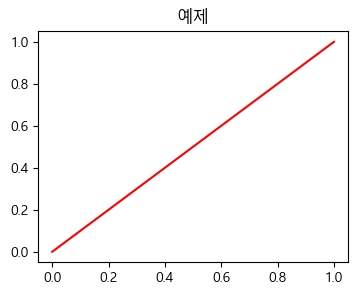

In [2]:
from utils.korean_font_setup import setup_korean_font

In [3]:
from lifelines import KaplanMeierFitter, CoxPHFitter

df_km = pd.DataFrame({
    "duration" : df_processed['duration_days'],
    "event": df_processed['이탈여부'],
    "step" : df_processed['단계']
})

df_km.head()

,duration,event,step
0,427,1,9
1,175,1,9
2,273,1,9
3,105,1,8
4,490,1,9


In [4]:
df[(df['이탈여부']=='P') & (df['단계']=='4') & (df['done_month'] == '0')]

,단계,payment_regdate,이탈여부,user_No,lvt,과외상태,stage_count,cycle_count,수업상태,과외일정,...,email_id,done_month,교과/탐구,학년,option,중단예정일,중단 예정 DONEMONTH,최초 개월 수,done_count,glvt_no
1242,4,2024-01-15 11:31,P,622345,80417,FINISH,1,2,RESERVATION,2024-01-24 16:00:00,...,parksb9914@gmail.com,0,교과,고3,W1_H60,2024-01-25 17:23,0,12,1,


### 단계
- 1단계: 결제는 되었으나 신청서도 작성 안 된 상태
- 2단계: 신청은 했으나 매칭/수업 시작 전
- 3단계: 선생님 매칭까지 되었으나 수업 시작 전
- 4단계: 수업 예약/진행/완료 중인 상태
- 5단계: 첫 수업 후 특별 옵션 옵션 케이스
- 6단계: 1개월 내 이탈한 케이스

In [4]:
df_km[(df_km['duration'] == 0) & (df_km['event']==1)]['step'].value_counts()

step
1    1876
3    1432
2     408
4       1
Name: count, dtype: int64

In [4]:
kmf = KaplanMeierFitter()

kmf.fit(durations=df_km['duration'], event_observed=df_km['event'], label="KM Estimate")

# 결과 확인
kmf.survival_function_

,KM Estimate
timeline,
0.0,0.856360
7.0,0.838318
14.0,0.821883
28.0,0.763715
35.0,0.742739
...,...
875.0,0.043657
882.0,0.043657
924.0,0.043657


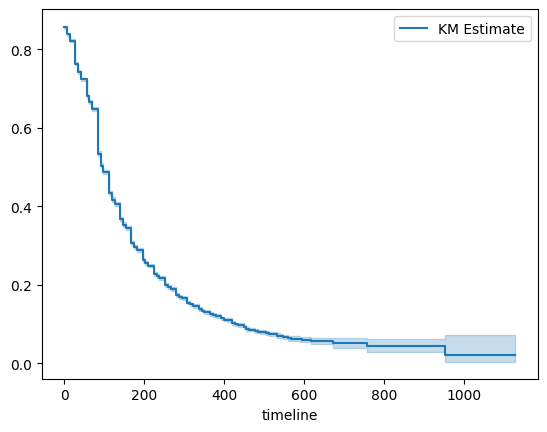

In [5]:
kmf.plot_survival_function()
plt.show()

In [12]:
# stage_count와 donemonth 관계 분석
print("=== stage_count와 donemonth 패턴 분석 ===")

# stage_count별 분포 확인
print("\n1. stage_count 분포:")
print(df_processed['stage_count'].value_counts().sort_index())

# stage_count > 1인 케이스들 분석
multi_stage = df_processed[df_processed['stage_count'] > 1]
print(f"\n2. stage_count > 1인 케이스: {len(multi_stage)}개 ({len(multi_stage)/len(df_processed)*100:.1f}%)")

if len(multi_stage) > 0:
    print("\n3. stage_count > 1인 케이스들의 donemonth 분포:")
    print(multi_stage.groupby('stage_count')['donemonth'].describe())
    
    # 샘플 케이스들 확인
    print("\n4. 샘플 케이스들:")
    sample_cases = multi_stage[['user_No', 'stage_count', 'donemonth', 'cycle_count', '이탈여부', '과외상태']].head(10)
    print(sample_cases)
    
    # 동일 user_No가 여러 stage에 나타나는지 확인
    print(f"\n5. 고유 user_No 수: {multi_stage['user_No'].nunique()}개")
    print(f"   전체 multi_stage 레코드 수: {len(multi_stage)}개")
    
    # 중복 user_No 확인
    duplicate_users = multi_stage['user_No'].value_counts()
    duplicate_users = duplicate_users[duplicate_users > 1]
    if len(duplicate_users) > 0:
        print(f"\n6. 중복된 user_No가 있는 경우: {len(duplicate_users)}개")
        print("   예시:")
        for user_no in duplicate_users.head(3).index:
            user_data = multi_stage[multi_stage['user_No'] == user_no][['user_No', 'stage_count', 'donemonth', '이탈여부']]
            print(f"   User {user_no}:")
            print(user_data.to_string(index=False))
            print()

=== stage_count와 donemonth 패턴 분석 ===

1. stage_count 분포:
stage_count
0      2310
1     16413
2      5312
3      3278
4      2345
5      1746
6      1352
7      1077
8       908
9       683
10      528
11      411
12      324
13      275
14      199
15      192
16      110
17      107
18       85
19       34
20       33
21       17
22        6
23        1
24        2
28        1
30        1
31        2
32        1
39        1
Name: count, dtype: int64

2. stage_count > 1인 케이스: 19031개 (50.4%)

3. stage_count > 1인 케이스들의 donemonth 분포:
              count       mean       std      min        25%      50%  \
stage_count                                                             
2            5312.0   3.356715  1.420819   0.0000   3.000000   3.3750   
3            3278.0   4.429863  1.380350   0.3750   4.000000   4.5000   
4            2345.0   5.401822  1.398352   0.2500   5.000000   5.5000   
5            1746.0   6.512730  1.521658   2.6250   6.000000   6.5000   
6            1352.0   7.4